In [2]:
!pip install -q sentence-transformers pandas numpy tqdm

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
#Loading LaBSE
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch

# Load LaBSE model
model = SentenceTransformer('sentence-transformers/LaBSE')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/804 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

2_Dense/model.safetensors:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

In [6]:
#Dataset
train_path = "/content/drive/MyDrive/msu-nlp/train_translated_full.csv"
dev_path   = "/content/drive/MyDrive/msu-nlp/dev_translated_full.csv"

train_df = pd.read_csv(train_path)
dev_df   = pd.read_csv(dev_path)

print(train_df.head())
print(dev_df.head())

     title                                            context  \
0  Beyoncé  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...   
1  Beyoncé  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...   
2  Beyoncé  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...   
3  Beyoncé  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...   
4  Beyoncé  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...   

                                            question          answer_text  \
0           When did Beyonce start becoming popular?    in the late 1990s   
1  What areas did Beyonce compete in when she was...  singing and dancing   
2  When did Beyonce leave Destiny's Child and bec...                 2003   
3      In what city and state did Beyonce  grow up?        Houston, Texas   
4         In which decade did Beyonce become famous?           late 1990s   

                                          context_hi  \
0  बेयॉन्से गिज़ेल नॉल्स-कार्टर (/biːˈjɒnseɪ/ bee...   
1  बेयॉन्से गिज़ेल नॉल्स-कार्टर (/

In [7]:
#Batchwise Embedding function
import numpy as np
from tqdm import tqdm

def get_embeddings(text_list, batch_size=32):
    """Efficient batch encoding using LaBSE"""
    all_embeddings = []

    for i in tqdm(range(0, len(text_list), batch_size)):
        batch = text_list[i : i + batch_size]
        emb = model.encode(batch, convert_to_numpy=True)
        all_embeddings.append(emb)

    return np.vstack(all_embeddings)


In [8]:
#Computing Similarities fro context & question
from numpy import dot
from numpy.linalg import norm

def cosine_sim(a, b):
    return dot(a, b) / (norm(a) * norm(b))


In [9]:
#Computing for Train set
# English
train_context_en = train_df["context"].astype(str).tolist()
train_question_en = train_df["question"].astype(str).tolist()

# Hindi
train_context_hi = train_df["context_hi"].astype(str).tolist()
train_question_hi = train_df["question_hi"].astype(str).tolist()

print("Embedding TRAIN English contexts...")
train_ctx_en_emb = get_embeddings(train_context_en)

print("Embedding TRAIN Hindi contexts...")
train_ctx_hi_emb = get_embeddings(train_context_hi)

print("Embedding TRAIN English questions...")
train_q_en_emb = get_embeddings(train_question_en)

print("Embedding TRAIN Hindi questions...")
train_q_hi_emb = get_embeddings(train_question_hi)


Embedding TRAIN English contexts...


100%|██████████| 4073/4073 [25:57<00:00,  2.61it/s]


Embedding TRAIN Hindi contexts...


100%|██████████| 4073/4073 [28:29<00:00,  2.38it/s]


Embedding TRAIN English questions...


100%|██████████| 4073/4073 [03:04<00:00, 22.07it/s]


Embedding TRAIN Hindi questions...


100%|██████████| 4073/4073 [03:47<00:00, 17.91it/s]


In [10]:
train_sim_context  = [cosine_sim(a, b) for a, b in zip(train_ctx_en_emb, train_ctx_hi_emb)]
train_sim_question = [cosine_sim(a, b) for a, b in zip(train_q_en_emb, train_q_hi_emb)]

train_df["sim_context"] = train_sim_context
train_df["sim_question"] = train_sim_question

In [11]:
out_train = "/content/drive/MyDrive/msu-nlp/train_with_labse_scores.csv"
train_df.to_csv(out_train, index=False)
print("Saved:", out_train)

Saved: /content/drive/MyDrive/msu-nlp/train_with_labse_scores.csv


In [37]:
train_out.head()

,title,context,question,answer_text,context_hi,question_hi,sim_context,sim_question
0,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,in the late 1990s,बेयॉन्से गिज़ेल नॉल्स-कार्टर (/biːˈjɒnseɪ/ bee...,बेयोंस कब से लोकप्रिय हो रही है?,0.897069,0.835107
1,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,singing and dancing,बेयॉन्से गिज़ेल नॉल्स-कार्टर (/biːˈjɒnseɪ/ bee...,जब वह बड़ी थी तो बेयोंस किस क्षेत्र में प्रतिस...,0.897069,0.839914
2,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,2003,बेयॉन्से गिज़ेल नॉल्स-कार्टर (/biːˈjɒnseɪ/ bee...,बेयोंस ने डेस्टिनी चाइल्ड को कब छोड़ दिया और ए...,0.897069,0.863307
3,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"Houston, Texas",बेयॉन्से गिज़ेल नॉल्स-कार्टर (/biːˈjɒnseɪ/ bee...,बेयोन्से किस शहर और राज्य में बड़ी हुई थी?,0.897069,0.885874
4,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,late 1990s,बेयॉन्से गिज़ेल नॉल्स-कार्टर (/biːˈjɒnseɪ/ bee...,बेयोंस किस दशक में प्रसिद्ध हुई?,0.897069,0.871347


In [12]:
#Computing for Dev set
# English
dev_context_en = dev_df["context"].astype(str).tolist()
dev_question_en = dev_df["question"].astype(str).tolist()

# Hindi
dev_context_hi = dev_df["context_hi"].astype(str).tolist()
dev_question_hi = dev_df["question_hi"].astype(str).tolist()

print("Embedding DEV English contexts...")
dev_ctx_en_emb = get_embeddings(dev_context_en)

print("Embedding DEV Hindi contexts...")
dev_ctx_hi_emb = get_embeddings(dev_context_hi)

print("Embedding DEV English questions...")
dev_q_en_emb = get_embeddings(dev_question_en)

print("Embedding DEV Hindi questions...")
dev_q_hi_emb = get_embeddings(dev_question_hi)

Embedding DEV English contexts...


100%|██████████| 372/372 [02:23<00:00,  2.60it/s]


Embedding DEV Hindi contexts...


100%|██████████| 372/372 [02:35<00:00,  2.40it/s]


Embedding DEV English questions...


100%|██████████| 372/372 [00:17<00:00, 21.80it/s]


Embedding DEV Hindi questions...


100%|██████████| 372/372 [00:20<00:00, 18.30it/s]


In [13]:
dev_df["sim_context"]  = [cosine_sim(a, b) for a, b in zip(dev_ctx_en_emb, dev_ctx_hi_emb)]
dev_df["sim_question"] = [cosine_sim(a, b) for a, b in zip(dev_q_en_emb, dev_q_hi_emb)]

In [14]:
out_dev = "/content/drive/MyDrive/msu-nlp/dev_with_labse_scores.csv"
dev_df.to_csv(out_dev, index=False)
print("Saved:", out_dev)

Saved: /content/drive/MyDrive/msu-nlp/dev_with_labse_scores.csv


In [38]:
dev_out.head()

,title,context,question,answer_text,context_hi,question_hi,sim_context,sim_question
0,Normans,The Normans (Norman: Nourmands; French: Norman...,In what country is Normandy located?,France,नॉर्मन (नॉर्मनः Nourmands; फ्रेंचः Normands; ल...,नॉरमैंडी किस देश में स्थित है?,0.901481,0.913680
1,Normans,The Normans (Norman: Nourmands; French: Norman...,When were the Normans in Normandy?,10th and 11th centuries,नॉर्मन (नॉर्मनः Nourmands; फ्रेंचः Normands; ल...,नॉर्मन नॉरमैंडी में कब थे?,0.901481,0.858882
2,Normans,The Normans (Norman: Nourmands; French: Norman...,From which countries did the Norse originate?,"Denmark, Iceland and Norway",नॉर्मन (नॉर्मनः Nourmands; फ्रेंचः Normands; ल...,नॉर्डिक किस देश से आते हैं?,0.901481,0.832563
3,Normans,The Normans (Norman: Nourmands; French: Norman...,Who was the Norse leader?,Rollo,नॉर्मन (नॉर्मनः Nourmands; फ्रेंचः Normands; ल...,नॉर्डिक नेता कौन था?,0.901481,0.874170
4,Normans,The Normans (Norman: Nourmands; French: Norman...,What century did the Normans first gain their ...,10th century,नॉर्मन (नॉर्मनः Nourmands; फ्रेंचः Normands; ल...,किस सदी में नॉर्मनों ने पहली बार अपनी अलग पहचा...,0.901481,0.912159


In [39]:
# Viewing similarity scores - Train
train_out[["sim_context", "sim_question"]].head()

,sim_context,sim_question
0,0.897069,0.835107
1,0.897069,0.839914
2,0.897069,0.863307
3,0.897069,0.885874
4,0.897069,0.871347


In [40]:
# Viewing similarity scores - Dev
dev_out[["sim_context", "sim_question"]].head()

,sim_context,sim_question
0,0.901481,0.913680
1,0.901481,0.858882
2,0.901481,0.832563
3,0.901481,0.874170
4,0.901481,0.912159


In [41]:
# Average Similarity - Train
print("Average context similarity:", train_out["sim_context"].mean())
print("Average question similarity:", train_out["sim_question"].mean())

Average context similarity: 0.8638284164676677
Average question similarity: 0.8689035781780475


In [42]:
# Weakest Values - Train
train_out.sort_values("sim_context").head(10)

,title,context,question,answer_text,context_hi,question_hi,sim_context,sim_question
15093,Endangered_Species_Act,Public notice is given through legal notices i...,Which court publishes legal notices?,NaN,"इस प्रकार, एक व्यक्ति को एक अन्य व्यक्ति के ना...",कौन सी अदालत कानूनी नोटिस प्रकाशित करती है?,0.121956,0.897548
15092,Endangered_Species_Act,Public notice is given through legal notices i...,What case took 45 days to be heard?,NaN,"इस प्रकार, एक व्यक्ति को एक अन्य व्यक्ति के ना...",किस मामले की सुनवाई में 45 दिन लगे?,0.121956,0.949389
15091,Endangered_Species_Act,Public notice is given through legal notices i...,How long does a public hearing last?,NaN,"इस प्रकार, एक व्यक्ति को एक अन्य व्यक्ति के ना...",सार्वजनिक सुनवाई कब तक चलती है?,0.121956,0.910154
15094,Endangered_Species_Act,Public notice is given through legal notices i...,What is not given to foreign nations?,NaN,"इस प्रकार, एक व्यक्ति को एक अन्य व्यक्ति के ना...",विदेशी राष्ट्रों को क्या नहीं दिया जाता है?,0.121956,0.912810
15088,Endangered_Species_Act,Public notice is given through legal notices i...,How long after a published notice of the listi...,45 days,"इस प्रकार, एक व्यक्ति को एक अन्य व्यक्ति के ना...",सूचीबद्ध होने की घोषणा के बाद सार्वजनिक सुनवाई...,0.121956,0.849986
15089,Endangered_Species_Act,Public notice is given through legal notices i...,Do listing notices cross international soil?,Foreign nations may also receive notice of a l...,"इस प्रकार, एक व्यक्ति को एक अन्य व्यक्ति के ना...",क्या सूचीबद्ध सूचनाएं अंतरराष्ट्रीय क्षेत्र से...,0.121956,0.789066
15090,Endangered_Species_Act,Public notice is given through legal notices i...,How are policy changes communicated to state a...,NaN,"इस प्रकार, एक व्यक्ति को एक अन्य व्यक्ति के ना...",नीतिगत परिवर्तनों को राज्यों और काउंटी को कैसे...,0.121956,0.876717
15087,Endangered_Species_Act,Public notice is given through legal notices i...,How is public notice given regarding a listing?,"through legal notices in newspapers, and commu...","इस प्रकार, एक व्यक्ति को एक अन्य व्यक्ति के ना...",सूचीबद्ध होने के संबंध में सार्वजनिक सूचना कैस...,0.121956,0.879311
60587,Aircraft_carrier,The current US fleet of Nimitz-class carriers ...,What will some of the current US fleet of Nimi...,the ten-ship Gerald R. Ford class,वर्तमान अमेरिकी नालीदार नालीदार नालीदार नालीदा...,निमिट्ज़-क्लास के वाहक के वर्तमान अमेरिकी बेड़...,0.205931,0.882278
60596,Aircraft_carrier,The current US fleet of Nimitz-class carriers ...,How much does the America-class amphibious pea...,NaN,वर्तमान अमेरिकी नालीदार नालीदार नालीदार नालीदा...,अमेरिका-वर्ग के उभयचर शांति जहाज का वजन कितना है?,0.205931,0.899570


In [32]:
train_out.sort_values("sim_question").head(10)

,title,context,question,answer_text,context_hi,question_hi,sim_context,sim_question
102443,Glacier,Crevasses can form in several different ways. ...,What kind of crevasses form where steep slopes...,NaN,दरारें कई अलग-अलग तरीकों से बन सकती हैं। पारदर...,किनारे किनारे किनारे किनारे किनारे किनारे किना...,0.813302,0.086112
23781,British_Isles,"At the end of the last ice age, what are now t...",Which countries were covered almost entirely b...,NaN,"पिछले हिमयुग के अंत में, जो अब ब्रिटिश द्वीप ह...",किनारे किनारे किनारे किनारे किनारे किनारे किना...,0.897016,0.166959
97074,Pope_Paul_VI,"Sacerdotalis caelibatus (Latin for ""Of the cel...",In what year was Canon Law issued affirming ce...,1983,24 जून 1967 को जारी की गई सैकर्डोटालिस कैलिबैट...,क्या आप जानते हैं कि क्या आप जानते हैं?,0.742670,0.185656
37136,Saint_Barth%C3%A9lemy,There are as many as 22 public beaches (most b...,What are leeward side beaches popular for?,NaN,सेंट बारथेलमी पर 22 सार्वजनिक समुद्र तट हैं (स...,किनारे किनारे किनारे किनारे किनारे किनारे किना...,0.939270,0.209566
108361,A_cappella,"A cappella [a kapˈpɛlla] (Italian for ""in the ...",A cappella was originally used to tell the dif...,Renaissance polyphony and Baroque concertato,"एक कैपेला [अ कप्पेला] (इतालवी के लिए ""चैपल के ...",क्या आप जानते हैं कि क्या आप जानते हैं कि क्या...,0.872421,0.221398
61076,Mesozoic,"Sea levels began to rise during the Jurassic, ...",Rising seas and displaced waters destroyed wha...,NaN,"ज्यूरासिक के दौरान समुद्र का स्तर बढ़ने लगा, ज...",किनारे किनारे किनारे किनारे किनारे किनारे किना...,0.884256,0.225278
61071,Mesozoic,"Sea levels began to rise during the Jurassic, ...",Rising seas and displaced waters caused what ...,flooded coastal areas,"ज्यूरासिक के दौरान समुद्र का स्तर बढ़ने लगा, ज...",किनारे किनारे किनारे किनारे किनारे किनारे किना...,0.884256,0.226653
6757,Plymouth,The Exeter to Plymouth railway of the LSWR nee...,In what month and year did storms affect the c...,February 2014,एलएसडब्ल्यूआर के एक्सटर-प्लीमाउथ रेलवे को सभी ...,डाउलिश के पास किनारे किनारे किनारे किनारे किना...,0.818472,0.255754
52433,Wood,"Structural material that resembles ordinary, ""...","Along with bamboo, what's the other monocot th...",palms,"सामान्य, ""डिकोट"" या गोलाकार लकड़ी की तरह संरचन...","बांस के साथ, बांस के साथ, बांस के साथ, बांस के...",0.882718,0.267912
107724,Turner_Classic_Movies,Turner Classic Movies essentially operates as ...,"Along with :35, :30, and :15 past the hour, at...",NaN,टर्नर क्लासिक फिल्में अनिवार्य रूप से एक वाणिज...,",,,, और,,, और,, के साथ साथ,......................",0.819427,0.271327


In [43]:
# Average Similarity - Dev
print("Average context similarity:", dev_out["sim_context"].mean())
print("Average question similarity:", dev_out["sim_question"].mean())

Average context similarity: 0.8651928882068558
Average question similarity: 0.8687965494778068


In [44]:
# Weakest Values - Dev
dev_out.sort_values("sim_context").head(10)

,title,context,question,answer_text,context_hi,question_hi,sim_context,sim_question
2530,Imperialism,"During the First Sino-Japanese War in 1894, Ja...",What didn't happen as a result of the Russo-J...,NaN,जापान ने चीन के साथ मिलकर चीन के साथ युद्ध में...,रूसी-जापानी युद्ध के परिणामस्वरूप क्या नहीं हुआ?,0.533929,0.890940
2528,Imperialism,"During the First Sino-Japanese War in 1894, Ja...",Which country did Japan force into an alliance?,Thailand,जापान ने चीन के साथ मिलकर चीन के साथ युद्ध में...,जापान ने किस देश को गठबंधन में शामिल करने के ल...,0.533929,0.848621
2531,Imperialism,"During the First Sino-Japanese War in 1894, Ja...",Which area of China did Japan conquer in 1935?,NaN,जापान ने चीन के साथ मिलकर चीन के साथ युद्ध में...,जापान ने 1935 में चीन के किस क्षेत्र पर विजय प...,0.533929,0.886325
2532,Imperialism,"During the First Sino-Japanese War in 1894, Ja...",Which country did Japan not force into an all...,NaN,जापान ने चीन के साथ मिलकर चीन के साथ युद्ध में...,जापान ने किस देश को गठबंधन में शामिल नहीं किया?,0.533929,0.835650
2529,Imperialism,"During the First Sino-Japanese War in 1894, Ja...",When was the last Sino-Japanese War?,NaN,जापान ने चीन के साथ मिलकर चीन के साथ युद्ध में...,अंतिम चीन-जापान युद्ध कब हुआ था?,0.533929,0.892955
2525,Imperialism,"During the First Sino-Japanese War in 1894, Ja...",When was the first Sino-Japanese War?,1894,जापान ने चीन के साथ मिलकर चीन के साथ युद्ध में...,पहला चीन-जापान युद्ध कब हुआ था?,0.533929,0.898719
2527,Imperialism,"During the First Sino-Japanese War in 1894, Ja...",Which area of China did Japan conquer in 1931?,Manchuria,जापान ने चीन के साथ मिलकर चीन के साथ युद्ध में...,जापान ने 1931 में चीन के किस क्षेत्र पर विजय प...,0.533929,0.888833
2526,Imperialism,"During the First Sino-Japanese War in 1894, Ja...",What happened as a result of the Russo-Japanes...,Japan took part of Sakhalin Island,जापान ने चीन के साथ मिलकर चीन के साथ युद्ध में...,रूस-जापान युद्ध के परिणामस्वरूप क्या हुआ?,0.533929,0.891326
5170,European_Union_law,In contrast to product requirements or other l...,Which two importers did not claim that under F...,NaN,उत्पाद आवश्यकताओं या बाजार तक पहुंच को रोकने व...,कौन से दो आयातकों ने दावा नहीं किया कि फ्रांसी...,0.573686,0.849872
5173,European_Union_law,In contrast to product requirements or other l...,Which case did the Court of Justice not review...,NaN,उत्पाद आवश्यकताओं या बाजार तक पहुंच को रोकने व...,किस मामले में 12 वर्ष से कम उम्र के बच्चों के ...,0.573686,0.825256


In [34]:
dev_out.sort_values("sim_question").head(10)

,title,context,question,answer_text,context_hi,question_hi,sim_context,sim_question
6577,Black_Death,The historian Francis Aidan Gasquet wrote abou...,What is another plague thought to have spread ...,the Justinian plague that was prevalent in the...,इतिहासकार फ्रांसिस आइडन गस्केट ने 1893 में 'ग्...,ऐसा क्या है?,0.843421,0.349621
9861,Yuan_dynasty,The historian Frederick W. Mote wrote that the...,There were many Mongols with what expected sta...,NaN,इतिहासकार फ्रेडरिक डब्ल्यू मोट ने लिखा कि इस प...,क्या स्थिति थी?,0.873463,0.469147
9860,Yuan_dynasty,The historian Frederick W. Mote wrote that the...,There were many Chinese with what expected sta...,NaN,इतिहासकार फ्रेडरिक डब्ल्यू मोट ने लिखा कि इस प...,क्या स्थिति थी?,0.873463,0.502758
9693,Yuan_dynasty,The Yuan undertook extensive public works. Amo...,How accurate did Guo make the formed lunisolar...,NaN,युआन ने व्यापक सार्वजनिक कार्य किए। कुब्लाई खा...,गुओ ने चंद्रमा की स्थापना की है।,0.832047,0.521863
7796,Construction,The project must adhere to zoning and building...,What is malum in se considerations?,the desire to prevent things that are indisput...,परियोजना को ज़ोन और बिल्डिंग कोड की आवश्यकताओं...,मॉलम क्या है?,0.882115,0.524061
7839,Construction,The owner produces a list of requirements for ...,What does the owner produce to show how to att...,NaN,मालिक एक परियोजना के लिए आवश्यकताओं की एक सूची...,लक्ष्य कैसे हासिल करें?,0.860263,0.539041
11696,Scottish_Parliament,"As in the House of Commons, a number of qualif...",What does being an MSP share with the House of...,a number of qualifications,"हाउस ऑफ कॉमन्स की तरह, एमएसपी होने के लिए कई य...",कमोडिटी पार्टी होने का क्या हिस्सा है?,0.895196,0.546086
3631,Force,A static equilibrium between two forces is the...,Complex devices such as weighing scales are us...,NaN,दो शक्तियों के बीच स्थैतिक संतुलन बल को मापने ...,क्या मापते हैं?,0.840914,0.564098
5300,Amazon_rainforest,There is evidence that there have been signifi...,What did the analysis from the sediment deposi...,rainfall in the basin during the LGM was lower...,"पिछले 21,000 वर्षों में अंतिम हिमवर्षाई अधिकतम...",जमावों से क्या पता चला?,0.799218,0.576272
7002,Geology,"In the laboratory, stratigraphers analyze samp...",What are well logs?,NaN,"प्रयोगशाला में, स्ट्रैटिग्राफरों ने क्षेत्र से...",कुएं का लकड़ी क्या है?,0.846697,0.579055


In [45]:
# Visualization


📌 TRAIN PLOTTING for: sim_context
sim_context — TRAIN:
Q1: 0.8424, Q3: 0.8928
IQR: 0.0504
Lower Fence: 0.7667
Upper Fence: 0.9684



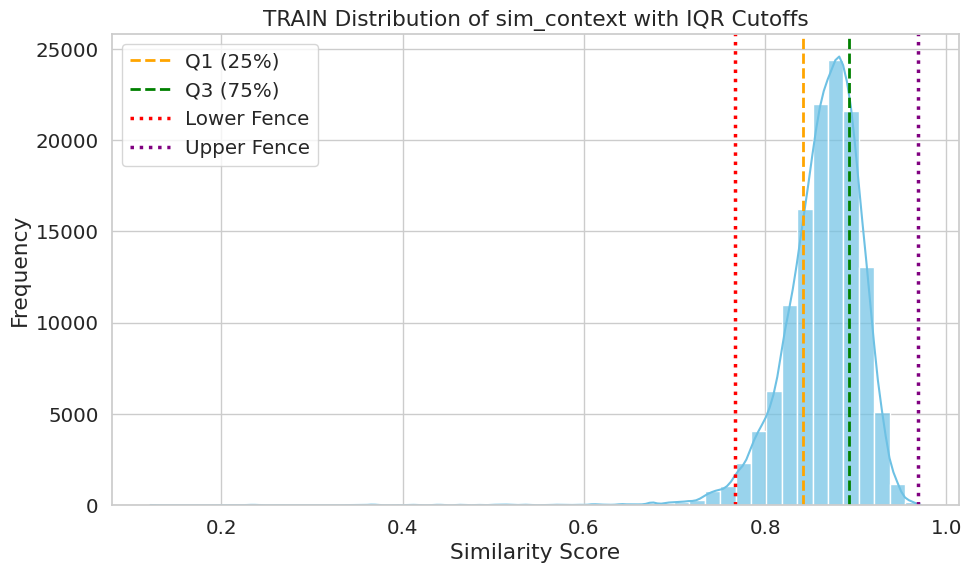

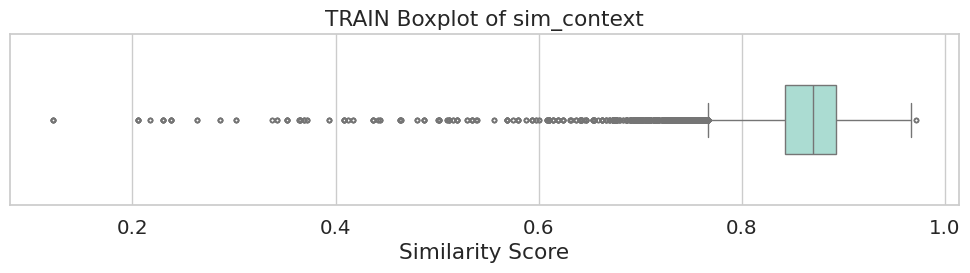


📌 TRAIN PLOTTING for: sim_question
sim_question — TRAIN:
Q1: 0.8451, Q3: 0.9020
IQR: 0.0569
Lower Fence: 0.7597
Upper Fence: 0.9874



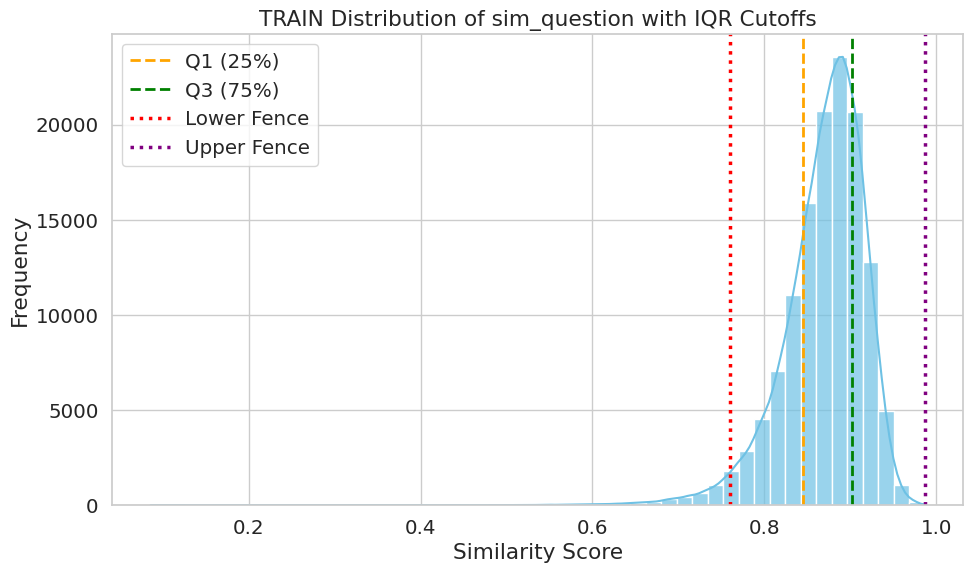

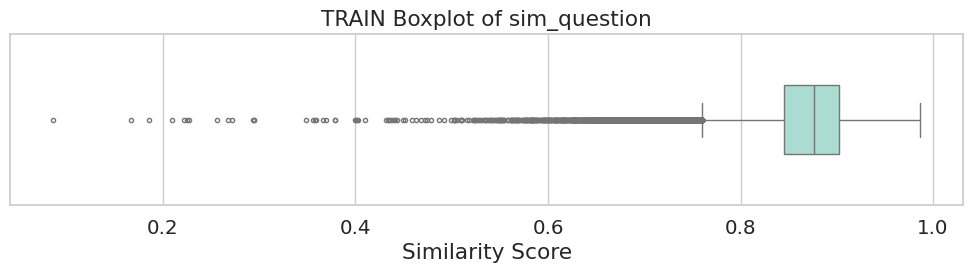

In [50]:
# Train Plots
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Beautiful style
sns.set_theme(style="whitegrid", palette="pastel", font_scale=1.3)

# Load TRAIN dataset
train = pd.read_csv("/content/drive/MyDrive/msu-nlp/train_with_labse_scores.csv")

cols = ["sim_context", "sim_question"]

for col in cols:
    print(f"\n📌 TRAIN PLOTTING for: {col}")
    print("="*35)

    # IQR stats for TRAIN
    Q1 = train[col].quantile(0.25)
    Q3 = train[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # Print IQR block
    print(f"{col} — TRAIN:")
    print(f"Q1: {Q1:.4f}, Q3: {Q3:.4f}")
    print(f"IQR: {IQR:.4f}")
    print(f"Lower Fence: {lower:.4f}")
    print(f"Upper Fence: {upper:.4f}\n")

    # ---------- HISTOGRAM ----------
    plt.figure(figsize=(10,6))
    sns.histplot(train[col], bins=50, kde=True, color="#6EC1E4", alpha=0.7)

    plt.axvline(Q1, color='orange', linestyle='--', linewidth=2, label="Q1 (25%)")
    plt.axvline(Q3, color='green', linestyle='--', linewidth=2, label="Q3 (75%)")
    plt.axvline(lower, color='red', linestyle=':', linewidth=2.5, label="Lower Fence")
    plt.axvline(upper, color='purple', linestyle=':', linewidth=2.5, label="Upper Fence")

    plt.title(f"TRAIN Distribution of {col} with IQR Cutoffs")
    plt.xlabel("Similarity Score")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ---------- BOXPLOT ----------
    plt.figure(figsize=(10,3))
    sns.boxplot(x=train[col], color="#A3E4D7", width=0.4, fliersize=3)
    plt.title(f"TRAIN Boxplot of {col}")
    plt.xlabel("Similarity Score")
    plt.tight_layout()
    plt.show()



📌 DEV PLOTTING for: sim_context
sim_context — DEV:
Q1: 0.8424, Q3: 0.8927
IQR: 0.0503
Lower Fence: 0.7669
Upper Fence: 0.9681



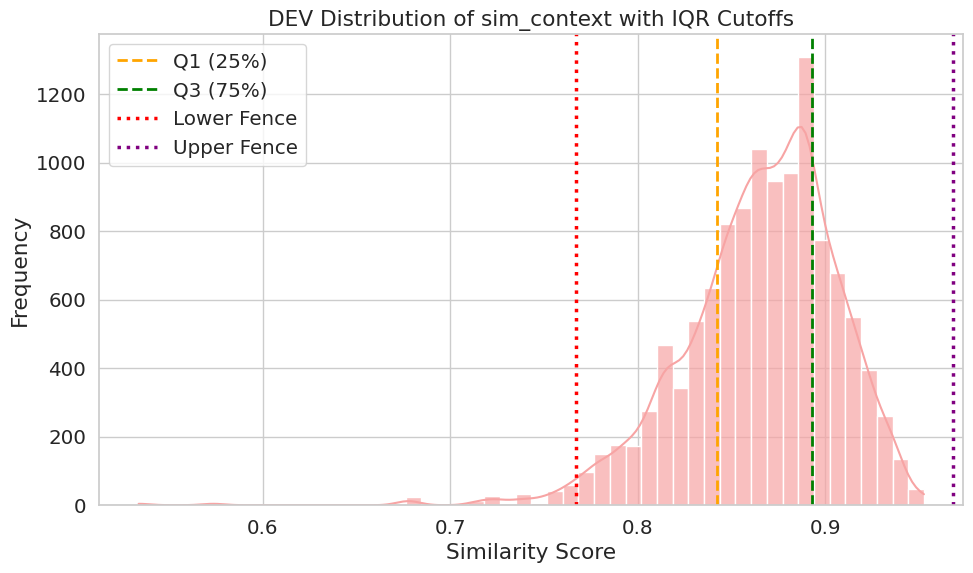

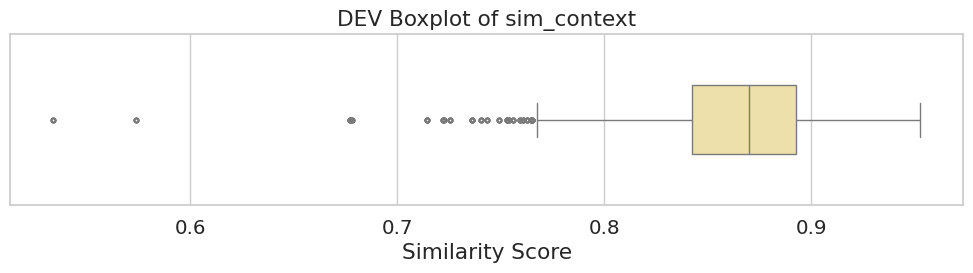


📌 DEV PLOTTING for: sim_question
sim_question — DEV:
Q1: 0.8454, Q3: 0.9006
IQR: 0.0552
Lower Fence: 0.7626
Upper Fence: 0.9834



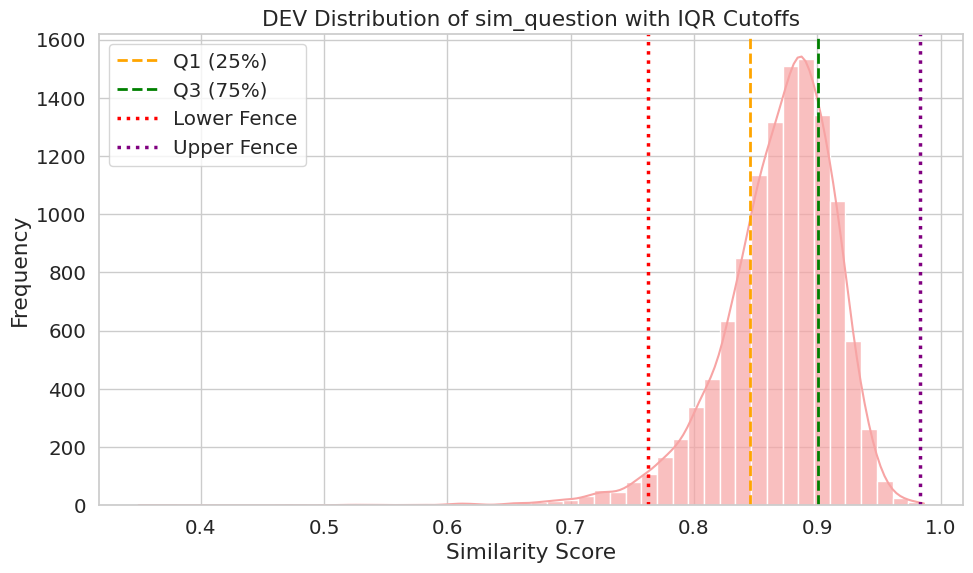

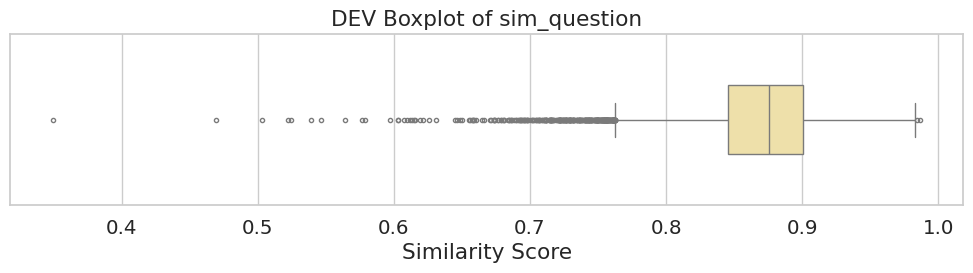

In [51]:
# Dev Plots
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Beautiful style
sns.set_theme(style="whitegrid", palette="pastel", font_scale=1.3)

# Load DEV dataset
dev = pd.read_csv("/content/drive/MyDrive/msu-nlp/dev_with_labse_scores.csv")

cols = ["sim_context", "sim_question"]

for col in cols:
    print(f"\n📌 DEV PLOTTING for: {col}")
    print("="*35)

    # IQR stats for DEV
    Q1 = dev[col].quantile(0.25)
    Q3 = dev[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # Print IQR block
    print(f"{col} — DEV:")
    print(f"Q1: {Q1:.4f}, Q3: {Q3:.4f}")
    print(f"IQR: {IQR:.4f}")
    print(f"Lower Fence: {lower:.4f}")
    print(f"Upper Fence: {upper:.4f}\n")

    # ---------- HISTOGRAM ----------
    plt.figure(figsize=(10,6))
    sns.histplot(dev[col], bins=50, kde=True, color="#F7A4A4", alpha=0.7)

    plt.axvline(Q1, color='orange', linestyle='--', linewidth=2, label="Q1 (25%)")
    plt.axvline(Q3, color='green', linestyle='--', linewidth=2, label="Q3 (75%)")
    plt.axvline(lower, color='red', linestyle=':', linewidth=2.5, label="Lower Fence")
    plt.axvline(upper, color='purple', linestyle=':', linewidth=2.5, label="Upper Fence")

    plt.title(f"DEV Distribution of {col} with IQR Cutoffs")
    plt.xlabel("Similarity Score")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ---------- BOXPLOT ----------
    plt.figure(figsize=(10,3))
    sns.boxplot(x=dev[col], color="#F9E79F", width=0.4, fliersize=3)
    plt.title(f"DEV Boxplot of {col}")
    plt.xlabel("Similarity Score")
    plt.tight_layout()
    plt.show()


In [3]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

train = pd.read_csv("/content/drive/MyDrive/msu-nlp/train_translated_full.csv")
dev   = pd.read_csv("/content/drive/MyDrive/msu-nlp/dev_translated_full.csv")

all_context_en = " ".join(list(train["context"].astype(str)) + list(dev["context"].astype(str)))
all_context_hi = " ".join(list(train["context_hi"].astype(str)) + list(dev["context_hi"].astype(str)))

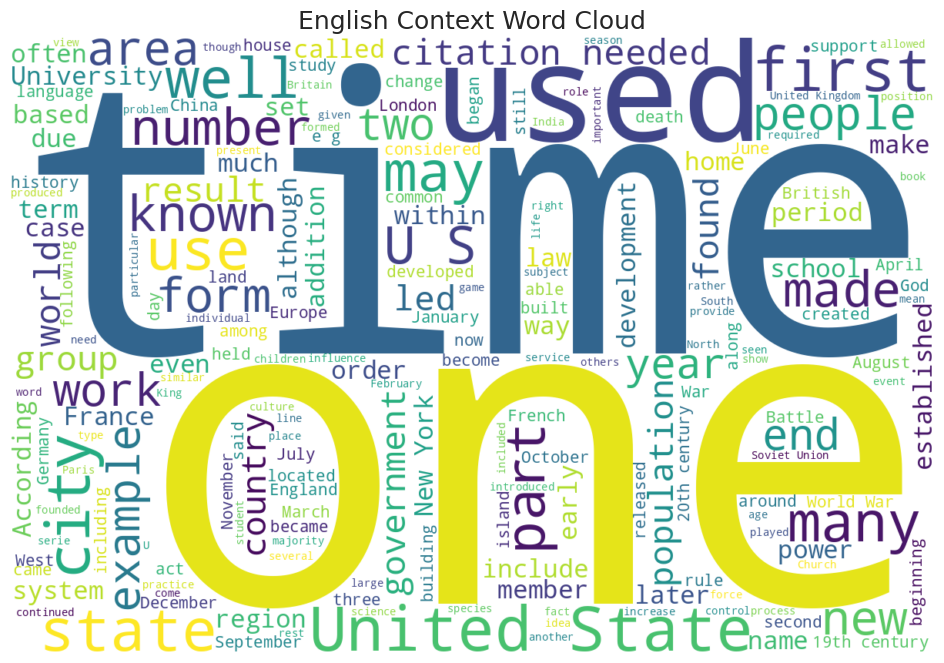

In [54]:
wc_en = WordCloud(
    width=1200,
    height=800,
    background_color="white",
    colormap="viridis"
).generate(all_context_en)

plt.figure(figsize=(12,8))
plt.imshow(wc_en, interpolation="bilinear")
plt.axis("off")
plt.title("English Context Word Cloud", fontsize=18)
plt.show()


In [9]:
#Summary Statistics
import pandas as pd

# Load both datasets
train = pd.read_csv("/content/drive/MyDrive/msu-nlp/train_with_labse_scores.csv")
dev   = pd.read_csv("/content/drive/MyDrive/msu-nlp/dev_with_labse_scores.csv")

def compute_summary(df, name):
    ctx = df["sim_context"]
    qst = df["sim_question"]

    # Basic stats
    avg_ctx = ctx.mean()
    avg_qst = qst.mean()

    # IQR
    Q1 = ctx.quantile(0.25)
    Q3 = ctx.quantile(0.75)
    IQR = Q3 - Q1
    lower_fence = Q1 - 1.5 * IQR

    # Percentages
    pct_good = (ctx > 0.85).mean() * 100
    pct_weak = (ctx < lower_fence).mean() * 100

    # Samples
    samples = len(df)

    # Print formatted summary
    print(f"\n📌 {name} TRANSLATION QUALITY SUMMARY (LaBSE)")
    print("=================================================")
    print(f"Average Similarity (Context): {avg_ctx:.4f}")
    print(f"Average Similarity (Question): {avg_qst:.4f}")
    print(f"IQR (Context): {IQR:.3f}")
    print(f"Good Translations (> 0.85): {pct_good:.1f}%")
    print(f"Weak Translations (< {lower_fence:.2f}): {pct_weak:.1f}%")
    print(f"Total Samples: {samples:,}")
    print("")

# Run for both datasets
compute_summary(train, "TRAIN")
compute_summary(dev,   "DEV")



📌 TRAIN TRANSLATION QUALITY SUMMARY (LaBSE)
Average Similarity (Context): 0.8638
Average Similarity (Question): 0.8689
IQR (Context): 0.050
Good Translations (> 0.85): 69.2%
Weak Translations (< 0.77): 2.3%
Total Samples: 130,319


📌 DEV TRANSLATION QUALITY SUMMARY (LaBSE)
Average Similarity (Context): 0.8652
Average Similarity (Question): 0.8688
IQR (Context): 0.050
Good Translations (> 0.85): 69.0%
Weak Translations (< 0.77): 1.8%
Total Samples: 11,873

